In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from neurorient import NeurOrient
from neurorient.utils_visualization import save_mrc
from neurorient.reconstruction.phasing import PhaseRetriever


In [3]:
spi_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/1bxr_train.pt')
model_dir = '/pscratch/sd/z/zhantao/neurorient_repo/model'
print(spi_data.keys())

dict_keys(['orientations', 'images', 'angles', 'points', 'pixel_position_reciprocal', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [4]:
model = NeurOrient.load_from_checkpoint('/pscratch/sd/z/zhantao/neurorient_repo/model/lightning_logs/version_14504328/checkpoints/last.ckpt')

In [6]:
model.to('cpu');

NeurOrient(
  (orientation_predictor): ResNet2Rotmat(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [7]:
slices_true = spi_data['images'][:10]
slices_target = torch.log(1 + slices_true).unsqueeze(1)

In [9]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions

with torch.no_grad():
    orientations = model.image_to_orientation(slices_target)
    # get reciprocal positions based on orientations
    # HKL has shape (3, num_qpts)
    HKL = gen_nonuniform_normalized_positions(
        orientations, model.pixel_position_reciprocal, model.over_sampling)
    # predict slices from HKL
    slices_pred = model.predict_slice(HKL).view((-1, 1,) + (model.image_dimension,)*2)
    
slices_pred = torch.exp(slices_pred) - 1
plt.imshow(slices_pred[3,0].detach(), vmax=slices_pred.max() * 1e-3)

In [12]:
import numpy as np

grid_reciprocal = model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(np.pi * grid_reciprocal.cpu())
intensity_pred = torch.exp(intensity) - 1
plt.imshow(intensity_pred[64], vmax=10)

In [16]:
phase_retriever = PhaseRetriever(n_phase_loops=30, beta=0.9)
rho_phased, support_phased = phase_retriever.phase(intensity_pred.sqrt())

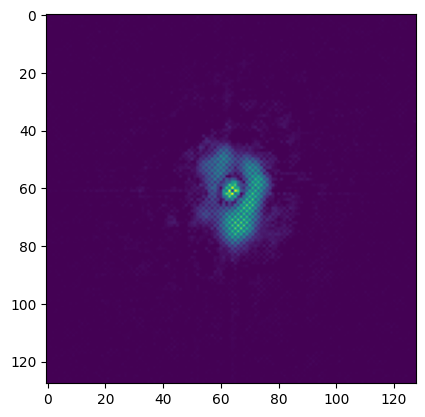

In [19]:
plt.imshow(rho_phased[64].clip(0))

In [20]:
save_mrc('1bxr.mrc', rho_phased.detach().cpu().numpy())